<a href="https://colab.research.google.com/github/VladutFlorian28/clock_reader_ml/blob/main/Copy_of_Reading_Analog_Clocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shivajbd_analog_clocks_path = kagglehub.dataset_download('shivajbd/analog-clocks')

print('Data source import complete.')


Data source import complete.


### Loading Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
pd.options.display.max_rows = 100

### Brief Exploration

In [4]:
#defining directory paths
image_dir = '/kaggle/input/analog-clocks/analog_clocks/images/'
labels_dir = '/kaggle/input/analog-clocks/analog_clocks/label.csv'

In [5]:
#examining labels
labels = pd.read_csv('C:\dev\clocks_reader\dataset\label.csv')
labels.describe()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\vladu\AppData\Local\Temp\ipykernel_29840\2049371419.py:2: SyntaxWarning: invalid escape sequence '\d'
  labels = pd.read_csv('C:\dev\clocks_reader\dataset\label.csv')


,hour,minute
count,50000.000000,50000.000000
mean,5.522940,29.531240
std,3.459953,17.210759
min,0.000000,0.000000
25%,3.000000,15.000000
50%,6.000000,30.000000
75%,9.000000,44.000000
max,11.000000,59.000000


In [6]:
#distribution of classes in hour column
labels.hour.value_counts(normalize=True)

hour
8     0.08580
11    0.08546
6     0.08462
10    0.08452
1     0.08428
2     0.08290
7     0.08286
3     0.08248
0     0.08246
4     0.08180
5     0.08164
9     0.08118
Name: proportion, dtype: float64

In [7]:
#distribution of classes in minute column
labels.minute.value_counts(normalize=True)

minute
37    0.01804
19    0.01790
39    0.01778
32    0.01776
44    0.01774
45    0.01744
13    0.01744
28    0.01736
17    0.01734
47    0.01732
4     0.01724
21    0.01718
22    0.01716
26    0.01710
16    0.01708
46    0.01706
34    0.01704
36    0.01702
23    0.01700
55    0.01692
50    0.01690
49    0.01688
27    0.01686
51    0.01684
33    0.01682
11    0.01680
7     0.01680
31    0.01674
42    0.01672
41    0.01670
38    0.01670
24    0.01662
18    0.01652
15    0.01652
48    0.01650
57    0.01646
6     0.01644
12    0.01644
8     0.01642
20    0.01642
1     0.01640
56    0.01632
3     0.01630
59    0.01630
29    0.01628
0     0.01626
9     0.01624
52    0.01614
40    0.01610
53    0.01602
54    0.01600
10    0.01598
35    0.01586
14    0.01580
5     0.01576
30    0.01574
25    0.01574
2     0.01566
58    0.01556
43    0.01552
Name: proportion, dtype: float64

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\vladu\AppData\Local\Temp\ipykernel_29840\13846457.py:2: SyntaxWarning: invalid escape sequence '\d'
  sample_dir = 'C:\dev\clocks_reader\dataset\samples'


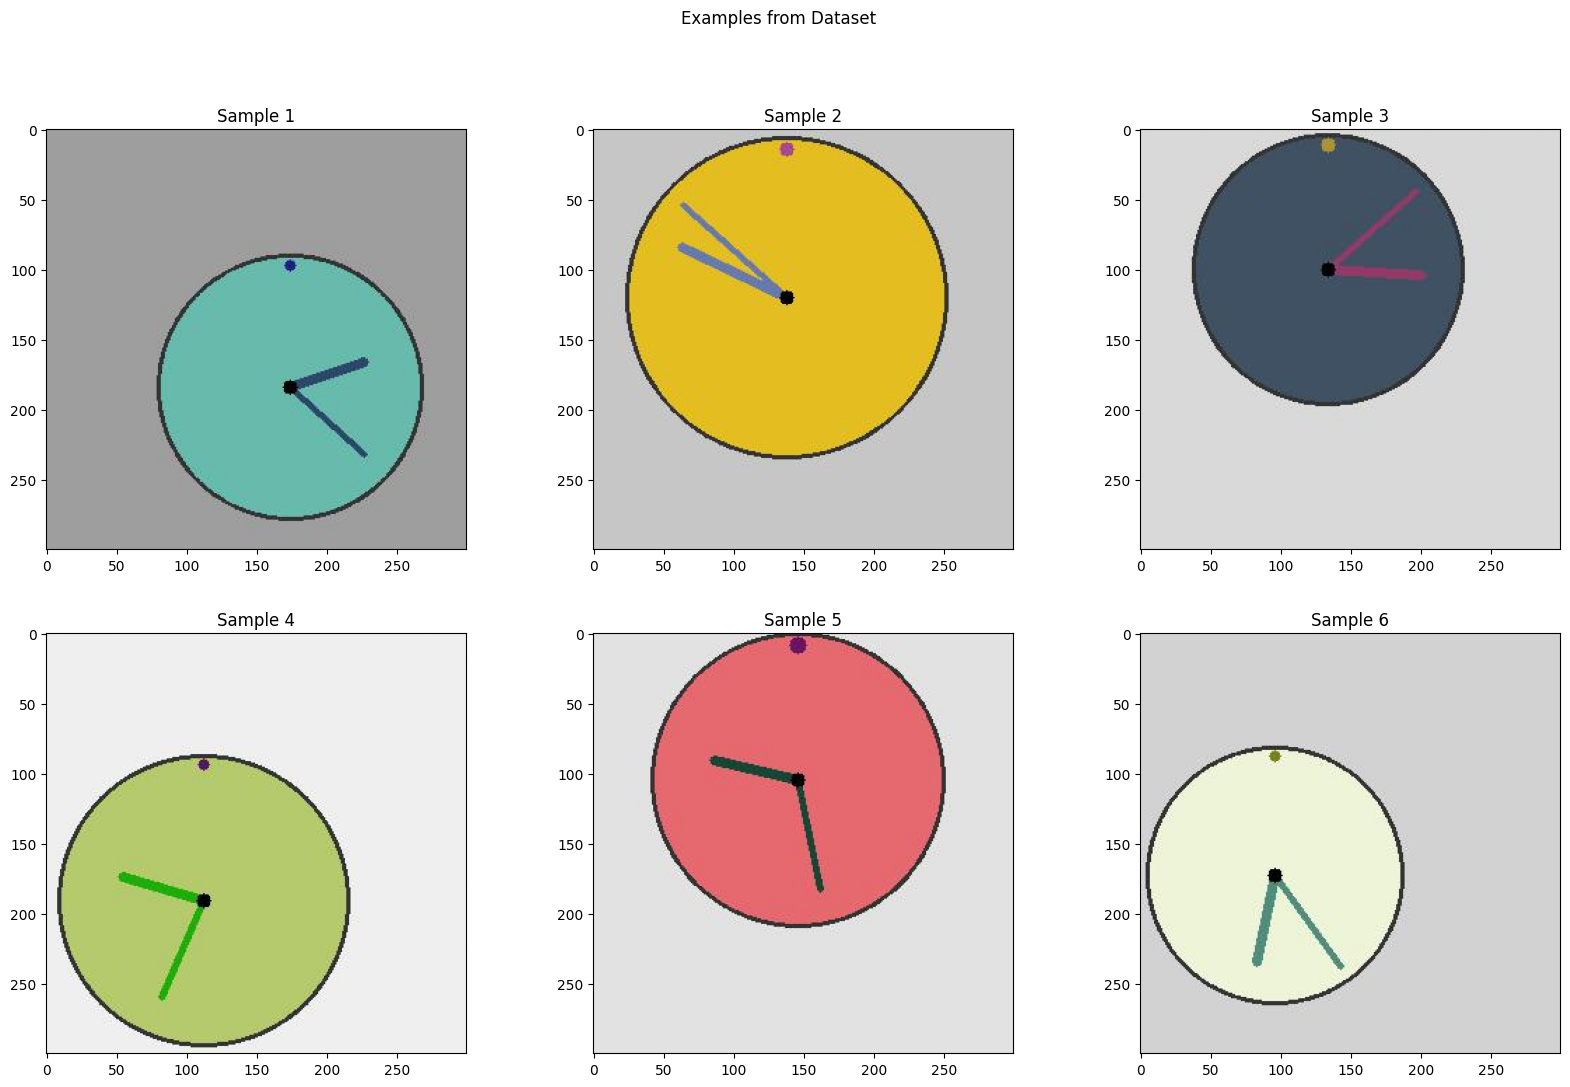

In [8]:
#preview of dataset
sample_dir = 'C:\dev\clocks_reader\dataset\samples'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('Examples from Dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

### Data Processing

In [9]:
#transforming labels to multi-label binary format
labels_df = pd.read_csv('C:\dev\clocks_reader\dataset\label.csv')
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
labels_df['tuples'] = [('h' + str(x), 'm' + str(y)) for x,y in labels_df['tuples'].values]
labels_df = labels_df.drop(columns=['hour', 'minute'])
# labels_df = labels_df.reset_index()
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\vladu\AppData\Local\Temp\ipykernel_29840\3996469403.py:2: SyntaxWarning: invalid escape sequence '\d'
  labels_df = pd.read_csv('C:\dev\clocks_reader\dataset\label.csv')


In [10]:
#preview of dataframe
labels_df.head()

,tuples
0,"(h4, m2)"
1,"(h9, m44)"
2,"(h3, m6)"
3,"(h3, m30)"
4,"(h2, m3)"


In [11]:
#distribution of unique labels
labels_df['tuples'].value_counts()

tuples
(h7, m22)     94
(h4, m4)      94
(h10, m48)    93
(h1, m24)     92
(h6, m32)     92
              ..
(h6, m27)     48
(h9, m7)      47
(h9, m48)     47
(h2, m30)     47
(h7, m35)     46
Name: count, Length: 720, dtype: int64

In [12]:
#creating train-test split
train, test = train_test_split(labels_df,
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [13]:
def generate(labels, train_idx=None, batch_size=64, size=(224, 224)):

    IMAGE_DIR = r"C:\dev\clocks_reader\dataset\images"

    prebuilt_model = xception.Xception(include_top=True, weights='imagenet')
    xception_model = Model(
        inputs=prebuilt_model.input,
        outputs=prebuilt_model.layers[-2].output
    )

    while True:

        if train_idx is None:
            image_filenames = os.listdir(IMAGE_DIR)
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]

        random.shuffle(image_filenames)

        image_batch = []
        labels_batch = []

        for file in image_filenames:

            index = int(file.split('.')[0])

            img = image.load_img(
                os.path.join(IMAGE_DIR, file),
                target_size=size,
                interpolation='box'
            )

            img_arr = image.img_to_array(img, dtype='float32')

            label = labels[index]

            image_batch.append(img_arr)
            labels_batch.append(label)

            if len(image_batch) == batch_size:
                image_batch = np.array(image_batch)
                image_batch = xception.preprocess_input(image_batch)

                image_features = xception_model.predict(image_batch)

                yield image_features, np.array(labels_batch)

                image_batch = []
                labels_batch = []
                gc.collect()


In [14]:
#Defining training parameters
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [15]:
sample_generator = next(generate(
    labels=y,
    train_idx=train_idx,
    batch_size=1,
    size=IMAGE_SIZE
))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


In [16]:
#output of generator
sample_generator

(array([[0.        , 0.        , 0.        , ..., 0.09662209, 0.2034581 ,
         0.0423242 ]], shape=(1, 2048), dtype=float32),
 array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

In [17]:
#extracting input and output dims from generator
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [18]:
print(INPUT_DIM, OUTPUT_DIM)

(2048,) 72


In [19]:
def create_model(input_shape, output_shape):

    """
    Function to build and compile neural network to predict analog clocks from images

    Parameters
    ----------
    input_shape: tuple
        Shape tuple not including the batch_size, example: (2048, )
    output_shape: int
        Number of nodes in final layer

    Returns
    -------
    model: Keras model object
        A compiled Keras model
    """

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)

    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)

    #compiling model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )

    return model

In [20]:
#creating instance of model
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 72)             │        18,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,032 (2.35 MB)

 Trainable params: 612,936 (2.34 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [22]:
generator = generate(
    labels=y,
    train_idx=train_idx,
    batch_size=BATCH_SIZE,
    size=IMAGE_SIZE
)

In [23]:
#fitting model
history = model.fit(generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS)

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step accuracy: 0.0518 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/stepaccuracy: 0.0510 - lo
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step accuracy: 0.0492 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step accuracy: 0.0472 - lo
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step accuracy: 0.0454 - lo
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step accuracy: 0.0437 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step4s/step - accuracy: 0.0424 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step5s/step - accuracy: 0.0415 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step5s/step - accuracy: 0.0407 - lo
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step5s/step - accuracy: 0.0404 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step5s/step - accuracy: 0.0406 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step5s/step - accuracy: 0.0413 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step6s/step - accuracy: 0.0424 - lo
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step6s/step - accuracy: 0.0438 - l
8/8 ━━━━━━━━━━━━━━━━━━━━ 16

KeyboardInterrupt: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


### Model Prediction on Sample

In [ ]:
def predict(image_directory, indices=None, plot=False):

    """
    Function to predict all images in a given path

    Parameters
    ----------
    image_directory: str
        Path for images to be predicted
    indices: list, default = None
        Indices corresponding to image labels to predict
    plot: boolean, default=False
        Whether or not to create plot of predictions

    Returns
    -------
    predictions_list: list
        List of predictions corresponding to the images
    """

    images_list = []

    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')           #loading pre-built model

    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output) #repurposing pre-built model for feature extraction

    if indices!=None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)

    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim,
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)

#         axs = axs.flatten()


    #looping over all images in path
    for i, file in enumerate(image_filenames):


        img = image.load_img(os.path.join(image_directory,
                                          file))                     #loading images
        img_arr = image.img_to_array(img, dtype='float32')           #converting images to array

        if plot:
            axs.flat[i].imshow(img_arr/255.0)

        images_list.append(img_arr)
        gc.collect()

    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)                 #preprocessing image array using xception method
    print('extracting features...')
    img_features = xception_model.predict(img_arr)                   #extracting features from image using prebuilt xception model
    img_features = np.array(img_features)
    print('predicting...')
    prediction = model.predict(img_features)                         #predicting time from image features
    hour_max = np.argmax(prediction[:, :12], axis=1)                 #obtaining hour with the highest probability
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12          #obtaining minute with the highest probability
    prediction_list = [(binarizer.classes_[x],                       #getting labels for predictions for binarizer
                        binarizer.classes_[y])
                        for (x,y) in list(zip(hour_max, minute_max))]

    if plot:                                                         #setting title for plots
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')
        for j in range(i+1, dim**2):                                 #removing excess subplots
              fig.delaxes(axs.flat[j])

    return prediction_list


In [ ]:
#predicting samples used in earlier vizualization
predictions = predict('/kaggle/input/analog-clocks/analog_clocks/samples/',
                        plot=True)

In [ ]:
#taking sample of test set to visualize results on unseen data
#this is done due to memory limitations
SIZE = 64
sample_test = list(np.random.choice(test_idx, size=SIZE))

In [ ]:
#predicting sample of test set
predictions = predict('/kaggle/input/analog-clocks/analog_clocks/images/',
                        indices=sample_test,
                        plot=True)

In [ ]:
sample_results = pd.DataFrame(list(zip(labels_df.loc[sample_test]['tuples'].values, pd.Series(predictions))), columns=['Actual', 'Predicted'])
sample_results

In [ ]:
#saving model
for layer in model.layers:
    layer.trainable = False
model.save('model')

### Take Aways

- Prebuilt models are very useful to extract features in this case
- Treating this problem as a multi-label classification achieves the best results over multi-class, possible due to lower dimensionality of labels (72 verus 720)
    - Initially tried having two outputs to the model, one for hours and one for minutes, but the model prioritizes optimizing hours over minutes
- Model performs well on unseen data
    - Since hours have less categories (12) their prediction is generally more accurate than the minutes (60)
    - The errors made by the model are reasonable
    - Since there are no minute-marker ticks on the clocks, even human eye can struggle to tell exact minute